# Methods

In [1]:
import numpy as np
from scipy.special import comb, factorial

def eulerian_number(n, m):
    acc = 0L

    for k in range(m + 1):
        c = comb(n + 1, k, exact=True)
        acc += (-1) ** k * c * ((m + 1 - k) ** n)

    return acc


def sigmoid(z):
    return 1 / (1 + np.exp(- z))


def sigmoid_derivative(z, n=2):
    sigma_z = sigmoid(z)

    acc = np.float128(0.0)

    for k in range(1, n + 1):
        acc += ((-1) ** (k - 1)) * np.float128(eulerian_number(n, k - 1)) * (sigma_z ** k) * ((1 - sigma_z) ** (n + 1 - k))

    return acc


# Load RBM (using https://github.com/coppolachan/rbm_ising to use data from research group)

In [2]:
import torch
import rbm_pytorch

In [3]:
CHECKPOINT = "models/L8/1.8/trained_rbm.pytorch.last"

In [4]:
rbm = rbm_pytorch.RBM(64, 64)

rbm_pytorch.py:106: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.W,mean=0, std=0.01)


In [5]:
rbm.load_state_dict(torch.load(CHECKPOINT))

# Compute bounds

We can write the (n + 1)-th cumulant as

\begin{equation*}
\kappa_{\mu}^{(n + 1)} = \sum_{k=1}^{n} \big( -1 \big)^{k - 1} A_{n, k-1} \sigma (b_{\mu})^k \big( 1 - \sigma(b_{\mu}) \big)^{n + 1 - k}
\end{equation*}

Or equivalently, by shifting \\(k\\) by \\(-1\\),

\begin{equation*}
\kappa_{\mu}^{(n + 1)} = \sum_{k = 0}^{n - 1} \big( -1 \big)^k A_{n, k} \sigma(b_{\mu})^{k + 1} \big( 1 - \sigma(b_{\mu}) \big)^{n - k}
\end{equation*}

Consider the case where \\(b_{\mu} \in [a, b]\\) for some *bounded* non-degenerate interval with \\(a, b \in \mathbb{R}\\), and let

\begin{equation*}
\alpha = \max \left\{ \max_{b_{\mu} \in [a, b]} \sigma(b_{\mu}), \max_{b_{\mu} \in [a, b]} \big( 1 - \sigma(b_{\mu}) \big) \right\}
\end{equation*}

we observe

\begin{equation*}
\begin{split}
  \left| \kappa_{\mu}^{(n + 1)} \right| &= \left| \sum_{k=0}^{n - 1} \big( - 1 \big)^k A_{n, k} \sigma(b_{\mu})^{k + 1} \big( 1 - \sigma(b_{\mu} \big)^{n - k} \right| \\
  &\le \sum_{k=0}^{n - 1} \left| A_{n, k} \right| \left| \sigma(b_{\mu})^{k + 1} \big( 1 - \sigma(b_{\mu}) \big)^{n - k} \right| \\
  & \le \sum_{k=0}^{n - 1} \left| A_{n, k} \right| \alpha^{k + 1} \alpha^{n - k} \\
  &= \alpha^{n + 1} \sum_{k=0}^{n - 1} A_{n, k} \\
  &= \alpha^{n + 1} n!
\end{split}
\end{equation*}

where we've used the fact that

\begin{equation*}
A_{n, k} \ge 0, \quad \forall n \in \mathbb{N} \quad \text{and} \quad \sum_{k=0}^{n - 1} A_{n, k} = n!, \quad n \ge 1
\end{equation*}

Relating to the coefficient of the Taylor expansion for the energy, we instead consider \\(\kappa_{\mu}^{(n + 1)} / (n + 1)!\\):

\begin{equation*}
\frac{\left| \kappa_{\mu}^{(n + 1)} \right|}{(n + 1)!} \le \frac{\alpha^{n + 1}}{n + 1}
\end{equation*}

Or wrt. $n$:

\begin{equation*}
\frac{\left| \kappa_{\mu}^{(n)} \right|}{n!} \le \frac{\alpha^{n}}{n}
\end{equation*}

In [6]:
z = np.float128(rbm.h_bias.detach().numpy())

Compute

$$
\frac{\left| \kappa^{(n)} \right|}{n!} = \frac{\left| \sigma^{(n - 1)} \right|}{n!}
$$

and upper-bound 

$$
\frac{\alpha^{n}}{n}
$$

For $n = 39$

In [7]:
def K(c, t):
    return np.log(1 + np.exp(c + t))

In [8]:
def second_order_corr(b, W, j_1, j_2):
    return np.sum(K(b, W[:, j_1] + W[:, j_2]) - K(b, W[:, j_1]) - K(b, W[:, j_2]) + K(b, 0))

In [9]:
def sum_2nd_order_visible_interact(i, j, rbm, N, reduced_form=True):
    W = rbm.W.detach().numpy().astype(np.float128)  # `W` is of shape `(num_hidden, num_visible)`
    h_bias = rbm.h_bias.detach().numpy().astype(np.float128)
    num_hidden = rbm.h_bias.detach().numpy().shape[0]
    num_visible = rbm.v_bias.detach().numpy().shape[0]

    acc = np.float128(0.0)

    for n in range(2, N + 1):
        cumulant = (sigmoid_derivative(h_bias, n - 1)
                    / np.float128(factorial(n, exact=True)))
        # sum over all hiddens
        for mu in range(num_hidden):
            if reduced_form:
                acc += (cumulant[mu] * ((W[mu, i] + W[mu, j]) ** n
                                       - (W[mu, i] ** n) - (W[mu, j] ** n)))
            else:
                # sum from 1 to n - 1
                for m in range(1, n):
                    acc += (cumulant[mu] * np.float128(comb(n, m, exact=True))
                            * W[mu, i] ** (n - m) * W[mu, j] ** (m))

    return acc

In [10]:
W = rbm.W.detach().numpy().astype(np.float128)  # `W` is of shape `(num_hidden, num_visible)`
h_bias = rbm.h_bias.detach().numpy().astype(np.float128)
num_hidden = rbm.h_bias.detach().numpy().shape[0]
num_visible = rbm.v_bias.detach().numpy().shape[0]

In [11]:
num_hidden, num_visible

(64, 64)

In [12]:
j_1 = 0
j_2 = 50

np.sum(K(h_bias, W[:, j_1] + W[:, j_2]) - K(h_bias, W[:, j_1]) - K(h_bias, W[:, j_2]) + K(h_bias, 0))

0.3140769760029088336

In [13]:
second_order_corr(h_bias, W, 0, 50)

0.3140769760029088336

In [14]:
W[:, 29]

array([-0.99900466, -1.01663578, -0.7283209 ,  0.80812222,  0.52210301,
       -0.4037475 ,  0.63951564, -0.09615159, -0.60554785,  1.28079474,
       -0.41350132,  0.66145581, -0.15431361,  0.26588839,  0.37657112,
       -0.11457924,  0.9362455 , -0.2544412 , -0.72572851,  0.53286511,
       -0.35425586, -0.65258449,  0.14819427,  2.22131753,  0.32971331,
        0.15719196,  0.80350429, -0.22586316,  0.35439119,  0.98652613,
       -9.78945732,  0.81430548,  0.47546503,  0.2652342 ,  0.68889618,
       -0.5214923 ,  0.74836451, -0.21035796, -0.14243828,  0.34316513,
        0.32548866, -0.01734587,  0.95211208,  0.53234398,  0.26277971,
        0.17645143,  1.0014106 ,  0.09662115,  0.11859177,  0.01629535,
        0.24115568, -0.17900501, -0.48497149, -0.19814315, -0.82289398,
       -0.46516082, -0.16475298, -0.60469145, -0.67777091, -1.28062093,
        0.31573343,  0.7608918 , -0.35882226, -0.21334687], dtype=float128)

In [15]:
W[:, 38]

array([-9.16909993e-01, -5.07525623e-01, -4.08764452e-01,  2.24681926e+00,
       -5.35090744e-01,  6.77757740e-01, -3.80537301e-01, -1.02366698e+00,
        3.77354890e-01,  8.30093384e-01, -6.30870521e-01,  2.57448554e-01,
        1.65063310e+00, -1.32693291e+00, -5.06666824e-02, -1.14239407e+00,
       -1.08651555e+00,  2.05553246e+00,  9.79986489e-01,  4.97629434e-01,
       -4.92430717e-01,  5.79621601e+00,  5.41517913e-01,  8.78595531e-01,
        1.05193889e+00, -9.17601660e-02,  3.64297569e-01,  9.11253989e-01,
       -1.66300580e-01,  6.76470697e-02, -4.44246918e-01,  1.13444008e-01,
       -6.88761592e-01, -3.53543848e-01, -1.10215878e+00,  1.10354829e+00,
       -9.57548499e-01,  9.16358352e-01, -4.63191327e-03, -6.40625283e-02,
       -5.62666953e-01, -1.56622493e+00,  8.93407106e-01,  1.46120512e+00,
       -2.16699094e-01, -7.45756865e-01,  5.85669696e-01,  5.42266965e-01,
        1.19828820e-01,  2.23119125e-01,  8.09378996e-02, -2.58464718e+00,
       -1.45842230e+00, -

In [16]:
np.sort((W[:, 0] + W[:, 50]))

array([-4.69225621e+00, -3.32173461e+00, -2.41521212e+00, -2.32164562e+00,
       -2.31189457e+00, -2.29880238e+00, -1.93806240e+00, -1.63446027e+00,
       -1.60372925e+00, -1.52042696e+00, -1.48047802e+00, -1.47978500e+00,
       -1.34172034e+00, -1.27588999e+00, -1.21392742e+00, -1.20617726e+00,
       -1.17837083e+00, -9.30729121e-01, -8.22938219e-01, -8.18077222e-01,
       -6.26775146e-01, -6.15605220e-01, -5.33782735e-01, -5.10855228e-01,
       -4.69221868e-01, -4.21021700e-01, -4.20190021e-01, -3.28168400e-01,
       -2.67154574e-01, -2.53582120e-01, -2.47517675e-01, -1.98729843e-01,
       -1.88411862e-01, -1.58433855e-01, -1.40885562e-01, -4.42134142e-02,
       -2.89475918e-02, -1.79259181e-02, -2.62254477e-03,  9.14317667e-02,
        1.16985321e-01,  2.04177715e-01,  2.43887424e-01,  3.06401372e-01,
        3.14726770e-01,  3.93002691e-01,  4.08074647e-01,  5.10044634e-01,
        6.17765605e-01,  6.87857270e-01,  7.07625017e-01,  8.01165491e-01,
        8.12042236e-01,  

In [17]:
np.sort(W[:, 0]), np.sort(W[:, 50])

(array([-1.66643047, -1.51710773, -1.35232055, -1.24718487, -1.14776671,
        -1.07136083, -1.06051147, -0.99996996, -0.93248683, -0.83950281,
        -0.79426211, -0.73489577, -0.73206836, -0.72137684, -0.68063283,
        -0.67595267, -0.60741132, -0.50439143, -0.49186555, -0.47877166,
        -0.42700377, -0.42341158, -0.41132307, -0.40034994, -0.39763206,
        -0.38757595, -0.3627848 , -0.35450488, -0.32108402, -0.30670837,
        -0.24646461, -0.22933844, -0.21400431, -0.18746063, -0.13515538,
        -0.12653758, -0.1036194 , -0.10132436, -0.05416784,  0.08265611,
         0.12554641,  0.15594086,  0.26946461,  0.2991074 ,  0.3222557 ,
         0.38018569,  0.38058063,  0.45554122,  0.47099221,  0.51771134,
         0.68025959,  0.6809417 ,  0.75597978,  0.76587725,  0.81345898,
         0.86979347,  1.02227724,  1.24142027,  1.39208639,  1.45120668,
         1.47926748,  1.57710898,  2.45481539,  3.78137517], dtype=float128),
 array([-3.62089539, -2.92410254, -2.61100197,

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import seaborn as sns; sns.set()

In [20]:
import pandas as pd

('Max W:', 1.0)
('Max W:', 0.0)
('Max W:', 19.167415313974743185)
('Max kappa:', 0.12471006142351593091)
('Max W:', 182.8243525617839941)
('Max kappa:', 0.01584005257333552804)
('Max W:', 1366.377599430598453)
('Max kappa:', 0.0051600943016307887598)
('Max W:', 9400.641417131829134)
('Max kappa:', 0.0010591894399805113724)
('Max W:', 62351.726988200109435)
('Max kappa:', 0.00034040443923882917722)
('Max W:', 406031.95671019240578)
('Max kappa:', 7.4579096177610707724e-05)
('Max W:', 2617930.384154330537)
('Max kappa:', 2.546629892374690112e-05)
('Max W:', 16784675.729727786756)
('Max kappa:', 6.5394393917523789895e-06)
('Max W:', 107261224.97725544765)
('Max kappa:', 2.0264450882774113622e-06)
('Max W:', 684109226.1784393792)
('Max kappa:', 5.5199065554096320705e-07)
('Max W:', 4358113442.3683921862)
('Max kappa:', 1.6729672338358783501e-07)
('Max W:', 27743593009.05256702)
('Max kappa:', 4.8307906998648909984e-08)
('Max W:', 176538216241.94703703)
('Max kappa:', 1.4144942838295482953e

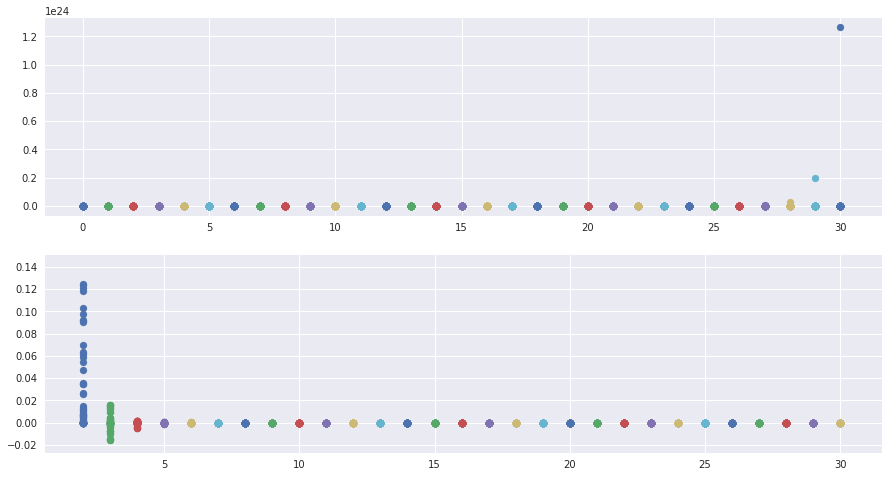

In [23]:
i = 0
j = 50

n = 30

d = []

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

for k in range(n + 1):
    t = ((W[:, i] + W[:, j]) ** k - (W[:, i] ** k)- (W[:, j] ** k))
    axes[0].scatter([k] * num_hidden, t)
    print("Max W:", np.max(np.abs(t)))
    
    if k >= 2:
        cumulants = (sigmoid_derivative(h_bias, k - 1) / np.float128(factorial(k, exact=True)))
        axes[1].scatter([k] * num_hidden, cumulants)
        print("Max kappa:", np.max(np.abs(cumulants)))
        
        # add to dataframe
        d.append({"W": np.max(np.abs(t)), "kappa": np.max(np.abs(cumulants)), "z": np.sum(cumulants * t)})

In [24]:
df = pd.DataFrame(d)

df

,W,kappa,z
0,1.916742e+01,1.247101e-01,1.437377e+00
1,1.828244e+02,1.584005e-02,2.430778e+00
2,1.366378e+03,5.160094e-03,-2.753242e+00
3,9.400641e+03,1.059189e-03,-9.941742e+00
4,6.235173e+04,3.404044e-04,-1.686830e+00
5,4.060320e+05,7.457910e-05,2.707638e+01
6,2.617930e+06,2.546630e-05,3.090465e+01
7,1.678468e+07,6.539439e-06,-5.172942e+01
8,1.072612e+08,2.026445e-06,-1.449903e+02
9,6.841092e+08,5.519907e-07,1.981997e+01


In [25]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &             W &         kappa &             z \\
\midrule
0  &  1.916742e+01 &  1.247101e-01 &  1.437377e+00 \\
1  &  1.828244e+02 &  1.584005e-02 &  2.430778e+00 \\
2  &  1.366378e+03 &  5.160094e-03 & -2.753242e+00 \\
3  &  9.400641e+03 &  1.059189e-03 & -9.941742e+00 \\
4  &  6.235173e+04 &  3.404044e-04 & -1.686830e+00 \\
5  &  4.060320e+05 &  7.457910e-05 &  2.707638e+01 \\
6  &  2.617930e+06 &  2.546630e-05 &  3.090465e+01 \\
7  &  1.678468e+07 &  6.539439e-06 & -5.172942e+01 \\
8  &  1.072612e+08 &  2.026445e-06 & -1.449903e+02 \\
9  &  6.841092e+08 &  5.519907e-07 &  1.981997e+01 \\
10 &  4.358113e+09 &  1.672967e-07 &  4.791551e+02 \\
11 &  2.774359e+10 &  4.830791e-08 &  4.108461e+02 \\
12 &  1.765382e+11 &  1.414494e-08 & -1.148652e+03 \\
13 &  1.123052e+12 &  4.089902e-09 & -2.499102e+03 \\
14 &  7.143163e+12 &  1.215321e-09 &  1.296267e+03 \\
15 &  4.542953e+13 &  3.606573e-10 &  9.660143e+03 \\
16 &  2.889079e+14 &  1.055642e-10 &  5.41

In [26]:
sum_2nd_order_visible_interact(0, 50, rbm, 30, reduced_form=True)

-27458558.666802163196

## Finding first `n` where UB fails

In [27]:
n = 39

In [28]:
# compute the abs of \kappa^{(n)}
kappa = np.abs(sigmoid_derivative(z, n=n - 1)) / np.float128(factorial(n), exact=True)

In [29]:
# compute upper-bounds
y = sigmoid(z)
alpha = np.max([y, 1 - y], axis=0)
ub = np.abs((alpha ** (n)) / (n))

In [30]:
# verify bounds
kappa <= ub

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Finding first $n$ for which the bounds fail.

In [ ]:
n = 0
correct = True

while correct:
    n += 1
    
    # compute the abs of \kappa^{(n)}
    kappa = np.abs(sigmoid_derivative(z, n=n - 1)) / np.float128(factorial(n), exact=True)

    # compute upper-bounds
    y = sigmoid(z)
    alpha = np.max([y, 1 - y], axis=0)
    ub = np.abs((alpha ** (n)) / (n))

    # verify bounds
    correct = np.all(kappa <= ub)

In [ ]:
kappa <= ub

In [93]:
kappa

array([1.61491962e-05, 3.55533496e-29, 2.28405172e-07, 1.05704827e-32,
       1.61927070e-31, 1.30556014e-04, 7.62998734e-07, 6.47725860e-24,
       6.98692335e-06, 6.45007633e-05, 9.28223184e-06, 7.94193143e-26,
       2.25194914e-11, 2.69243228e-07, 1.03306197e-26, 3.54596848e-07,
       4.36206731e-08, 9.53929727e-26, 3.69744578e-31, 1.51685070e-04,
       2.38916393e-07, 4.91592469e-31, 1.73972987e-05, 6.06524278e-47,
       1.04131329e-04, 1.11506362e-04, 1.07708298e-27, 8.29013409e-15,
       7.27261512e-11, 6.78345026e-46, 3.65219738e-06, 8.04953303e-06,
       1.29045498e-07, 8.63676305e-08, 2.35088433e-46, 8.55212670e-25,
       2.10132925e-06, 1.56175386e-07, 5.45113128e-05, 1.31307107e-04,
       1.32172482e-04, 2.25812779e-07, 3.17911768e-29, 2.59216667e-06,
       3.87233915e-05, 7.79620892e-38, 1.52315957e-04, 1.04995050e-06,
       1.17450058e-07, 1.43165210e-22, 9.59545445e-16, 3.73145623e-25,
       1.42101699e-07, 1.28262135e-06, 1.47667009e-39, 1.28092024e-06,
      

In [94]:
ub

array([2.39463989e-02, 8.01918308e-03, 2.49853751e-02, 1.70967161e-02,
       1.56630027e-02, 1.41047835e-02, 2.49511153e-02, 1.58909685e-05,
       2.45491416e-02, 1.09424589e-03, 7.17320446e-05, 2.74811018e-04,
       2.04979910e-11, 2.49827594e-02, 1.12904500e-03, 2.49772917e-02,
       1.10199834e-07, 4.55398260e-07, 1.22295547e-02, 9.81307153e-03,
       2.49847019e-02, 1.23493109e-02, 2.38632191e-02, 2.49974778e-02,
       2.54194807e-03, 1.63269125e-02, 1.00214732e-03, 1.49232918e-13,
       7.61922162e-11, 2.49848316e-02, 2.47652359e-02, 2.44799254e-02,
       2.49917381e-02, 2.49944707e-02, 2.49958582e-02, 1.28870281e-04,
       2.48651652e-02, 2.49900008e-02, 2.12479121e-02, 1.40035733e-02,
       1.38851142e-02, 2.49855411e-02, 7.37588031e-03, 2.48335768e-02,
       2.23971615e-02, 2.40882804e-02, 9.44346345e-03, 2.49327087e-02,
       2.49924805e-02, 2.96192991e-08, 1.15461027e-12, 4.03076618e-05,
       2.49909020e-02, 2.49177752e-02, 2.46705078e-02, 2.49178844e-02,
      

Since we observe that some values fail the upper-bound check, it might be useful to check if the following is verified for such large $n$:

$$
\sum_{m=0}^{n - 1} A_{n, m} = n!
$$

In [49]:
n = 100

In [54]:
factorial(n, exact=True) - np.sum([eulerian_number(n, m) for m in range(n)])

0L

In [53]:
np.sum([eulerian_number(n, m) for m in range(n)])

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000L

As we can see, there is a huge discrepancy between the two computations, implying that numerical error plays an important role in why we cannot get the series to converge numerically.